In [1]:
%matplotlib inline
from astropy.stats import sigma_clipped_stats
from photutils import CircularAperture, aperture_photometry, CircularAnnulus, DAOStarFinder
import astropy.io.fits as pf
import numpy as np
import seaborn as sns
sns.set()
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.wcs import WCS
from matplotlib import pyplot as plt
import os
from scipy import stats
from scipy.optimize import curve_fit
from scipy import odr

In [2]:
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project')
file = 'wcsM_0008.fits'
image = pf.open(file)
w = WCS(image[0].header)
sky = w.pixel_to_world(397,353)
print(sky)

<SkyCoord (FK5: equinox=2000.0): (ra, dec) in deg
    (101.78892166, 3.96714938)>


In [3]:
x = [101.806429,101.797486,101.766053,101.766058,101.771853]
y = [3.963025,3.990697,3.978969,3.951486,3.942408]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    print('{0} {1}'.format(px, py))

297.56287019361145 376.770583458653
350.5649450610539 218.24804207148318
529.6880101317572 287.3528019547881
527.8583589503173 445.27753613769084
494.0966201632183 497.12705573299945


In [4]:
x = [101.806429,101.797486,101.766053,101.766058,101.771853]
y = [3.963025,3.990697,3.978969,3.951486,3.942408]
a = []
b = []
for i,j in zip(x,y):
    px, py = w.wcs_world2pix(i,j, 1)
    a.append(px)
    b.append(py)
    #print('{0} {1}'.format(px, py))
    
os.chdir(r'C:\Users\garyc\Desktop\4th Year\Astro Project\1I Reduced')
file1 = 'reduceducdM_0007.fits'
image1 = pf.getdata(file1)
file2 = 'reduceducdM_0008.fits'
image2 = pf.getdata(file2)
#file3 = 'reduceducdM_0009.fits'
#image3 = pf.getdata(file3)
image = image1+image2#+image3

a = np.array(a)
b = np.array(b)
a = a
b = b
print(a)
print(b)
mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'

positions = []
for i,j in zip(a,b):
    ID = []
    xref = i
    yref = j
    for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
        if -5<(k-xref)<5 and -5<(l-yref)<5:
            n = m-1
            ID.append(n)
            positions.append((k,l))
    print(sources[ID])

[297.56287019 350.56494506 529.68801013 527.85835895 494.09662016]
[376.77058346 218.24804207 287.35280195 445.27753614 497.12705573]
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
464 294.76468 375.98755 0.73771648 ...   0 3765.0764 128.07895 -5.2686944
 id xcentroid ycentroid sharpness ... sky    peak      flux      mag    
--- --------- --------- --------- ... --- --------- --------- ----------
279  349.7965 217.10635 0.7470199 ...   0 3495.0762 118.09202 -5.1805514
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
359 529.35109 287.01477 0.69860344 ...   0 5666.8229 198.29874 -5.7432999
 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
550 527.74156 443.11627 0.71481215 ...   0 1130.0194 39

In [6]:
mags = []
magserrors = []
for i in positions:
    aperture = CircularAperture(i, r=6) 
    annulus_aperture = CircularAnnulus(i, r_in=12., r_out=15.)
    apers = [aperture, annulus_aperture]
    phot_table = aperture_photometry(image, apers)
    for col in phot_table.colnames:
        phot_table[col].info.format = '%.8g'
    bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
    bkg_total = bkg_mean * aperture.area
    net_star = phot_table['aperture_sum_0'] - bkg_total
    mags.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
    dfdx = -1.08574/phot_table['aperture_sum_0'][0]
    error = np.sqrt((dfdx**2)*(np.sqrt(phot_table['aperture_sum_0'][0]))**2)
    magserrors.append(error)

Beta: [  0.26238922 -15.99593163]
Beta Std Error: [0.01594151 0.21908647]
Beta Covariance: [[ 0.39726537 -5.45239107]
 [-5.45239107 75.03314565]]
Residual Variance: 0.0006397023561205543
Inverse Condition #: 0.01969241671485316
Reason(s) for Halting:
  Sum of squares convergence


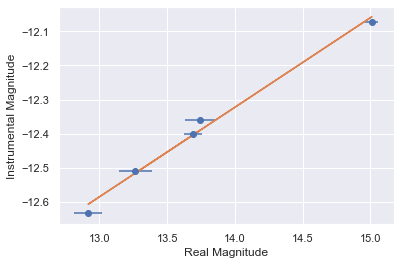

In [8]:
mags = np.array(mags)
Vmag = [15.219,14.947,13.599,15.702,13.739]
Vmag = np.array(Vmag)
Vmagerrors = [0.078,0.061,0.042,0.144,0.037]

rprime = [14.736,14.539,13.491,15.554,13.682]
rprimeerror = [0.081,0.064,0.068,0.066,0.049]

iprime = [14.19,14.201,13.339,15.427,13.660]
iprimeerror = [0.054,0.09,0.086,0.037,0.102]

Imag = []
Imagerror = []
for rp, ip, rperror, iperror in zip(rprime,iprime,rprimeerror,iprimeerror):
    r = rp +0.035*(rp-ip-0.21)
    rdrp = 1.035
    rdip = -0.035
    rerror = np.sqrt((rdrp**2)*rperror**2+(rdip**2)*iperror**2)
    
    i = ip + 0.041*(rp-ip-0.21)
    idrp = 0.041
    idip = 0.959
    ierror = np.sqrt((idrp**2)*rperror**2+(idip**2)*iperror**2)
    
   
    I = r-1.2444*(r-i)-0.382
    dr = -0.2444
    di = -1.2444
    Ierror = np.sqrt((dr**2)*(rerror**2)+(di**2)*(ierror**2))
    
    Imag.append(I)
    Imagerror.append(Ierror)
Imag = np.array(Imag)
Imagerror = np.array(Imagerror)


plt.errorbar(Imag,mags,xerr=Imagerror,yerr=magserrors,fmt='o')
plt.ylabel('Instrumental Magnitude')
plt.xlabel('Real Magnitude')

def func(p, x):
    m, c = p
    return m*x + c
mydata = odr.RealData(Imag, mags, sx = Imagerror, sy = None)
linear = odr.Model(func)
myodr = odr.ODR(mydata, linear,beta0 =[1, -23])
myoutput = myodr.run()
y = myoutput.beta[0]*Imag+myoutput.beta[1]
plt.plot(Imag,y)
myoutput.pprint()

In [9]:
xref = 399
yref = 353

mean, median, std = sigma_clipped_stats(image, sigma=3)
daofind = DAOStarFinder(fwhm=5.0, threshold=3*std) 
sources = daofind(image - median)
for col in sources.colnames: 
    sources[col].info.format = '%.8g'
for k,l,m in zip(sources['xcentroid'],sources['ycentroid'],sources['id']):
    if -10<(k-xref)<10 and -10<(l-yref)<10:
        n = m-1
        ID.append(n)
print(sources[ID])

 id xcentroid ycentroid sharpness  ... sky    peak      flux      mag    
--- --------- --------- ---------- ... --- --------- --------- ----------
624 493.24394 495.57686 0.75863572 ...   0 4669.5224 153.30301 -5.4638767
439 395.61629 353.01287 0.62475455 ...   0 125107.19 4767.0645 -9.1956276


In [10]:
sourcemag = []
sourcemagerror = []
position = [(395.78185,353.0515)]
aperture = CircularAperture(position[0], r=6) 
annulus_aperture = CircularAnnulus(position[0], r_in=12., r_out=15.)
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area
bkg_total = bkg_mean * aperture.area
net_star = phot_table['aperture_sum_0'] - bkg_total
sourcemag.append(-2.5*np.log10(phot_table['aperture_sum_0'][0]))
sourcemagerror.append(np.sqrt(((-1.08574/phot_table['aperture_sum_0'][0])**2)*(np.sqrt(phot_table['aperture_sum_0'][0])**2)))
print(sourcemag)

[-15.361903245876551]


In [11]:
dy = 1/myoutput.beta[0]
dc = -1/myoutput.beta[0]
dm = (myoutput.beta[1]-sourcemag[0])/(myoutput.beta[0])**2
error = np.sqrt((dy**2)*sourcemagerror[0]**2+(dc**2)*(myoutput.sd_beta[1])**2+(dm**2)*(myoutput.sd_beta[0])**2)
print((sourcemag[0]-myoutput.beta[1])/myoutput.beta[0],'+/-',error)

2.416365920008979 +/- 0.847782500898469
